# Završni rad - Otkrivanje znanja u podacima

1.	Razumijevanje problema

2.	Priprema podataka

3.	Istraživačka analiza podataka

4.	Oblikovanje baznog modela, balansiranje podataka, particija podataka (treniranje i testiranje)
    - filtriramo cjelokupni dataframe na [titleType=movie]
    - svodimo cjelokupni dataframe na bazni model [režiser, žanrovi, prosječna_ocjena]
    - balansiramo podatke tako da svaka prosječna_ocjena sadrži točno 40000 uzoraka nezavisnih varijabli
    - particioniramo podatke (66% train; 33% test)

5.	Primjena različitih postupaka strojnog učenja
    - Stabla odlučivanja
    - Slučajne šume
    - Support Vector Machine
    - MLPClassifier

6.	Odabir najboljeg modela, evaluacija (u odnosu na bazni model, model treba biti osjetljiv na cijenu pogreške)
    - Stabla odlučivanja
    - Slučajne šume

7.	Primjena u stvarnim uvjetima
    - Christopher Nolan
    - Lamberto Sanfelice

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import settings


TITLES_DTYPE = {
    'startYear'         : 'string',
    'titleType'         : 'string',
    'primaryTitle'      : 'string',
    'directorName'      : 'string',
    'genres'            : 'object',
    'averageRating'     : 'float',
    'numVotes'          : 'int',
    'runtimeMinutes'    : 'int',
}

rename_map = {
    'averageRating'     : 'Prosječna ocjena',
    'numVotes'          : 'Broj glasova',
    'numVotes_n'        : 'Broj glasova (n*)',
    'titleType'         : 'Tip naslova',
    'primaryTitle'      : 'Naziv naslova',
    'startYear'         : 'Godina',
    'runtimeMinutes'    : 'Trajanje (min)',
    'runtimeMinutes_n'  : 'Trajanje (min) (n*)',
    'genres'            : 'Žanrovi',
}

theme = {
    'primary': '#F5C611',
    'secondary': '#DEDDB8',
    'alternative': '#302000'
}

titles_df = pd.read_csv(os.path.join(settings.DATASET_DIR, 'master.csv'), dtype=TITLES_DTYPE)
titles_df = titles_df.loc[titles_df['startYear'] < '2022']
titles_df['genres'] = titles_df['genres'].apply(eval)

titles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456611 entries, 0 to 457438
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   startYear       456611 non-null  string 
 1   titleType       456611 non-null  string 
 2   primaryTitle    456611 non-null  string 
 3   directorName    456611 non-null  string 
 4   genres          456611 non-null  object 
 5   averageRating   456611 non-null  float64
 6   numVotes        456611 non-null  int32  
 7   runtimeMinutes  456611 non-null  int32  
dtypes: float64(1), int32(2), object(1), string(4)
memory usage: 27.9+ MB


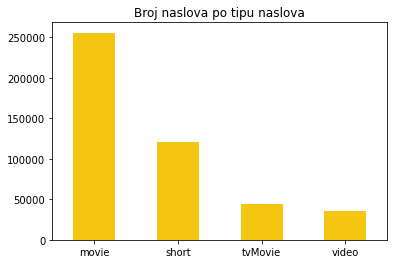

In [3]:
titles_df.titleType.value_counts() \
    .plot.bar(title='Broj naslova po tipu naslova', color=theme['primary'], rot=0)
plt.show()

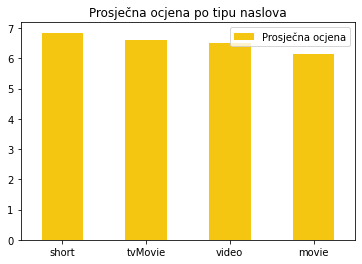

In [4]:
titles_df[['titleType', 'averageRating']]\
    .groupby('titleType').mean('averageRating') \
    .sort_values('averageRating', ascending=False).rename(columns=rename_map) \
    .plot.bar(title="Prosječna ocjena po tipu naslova", color=theme['primary'], rot=0)
plt.xlabel(None)
plt.show()

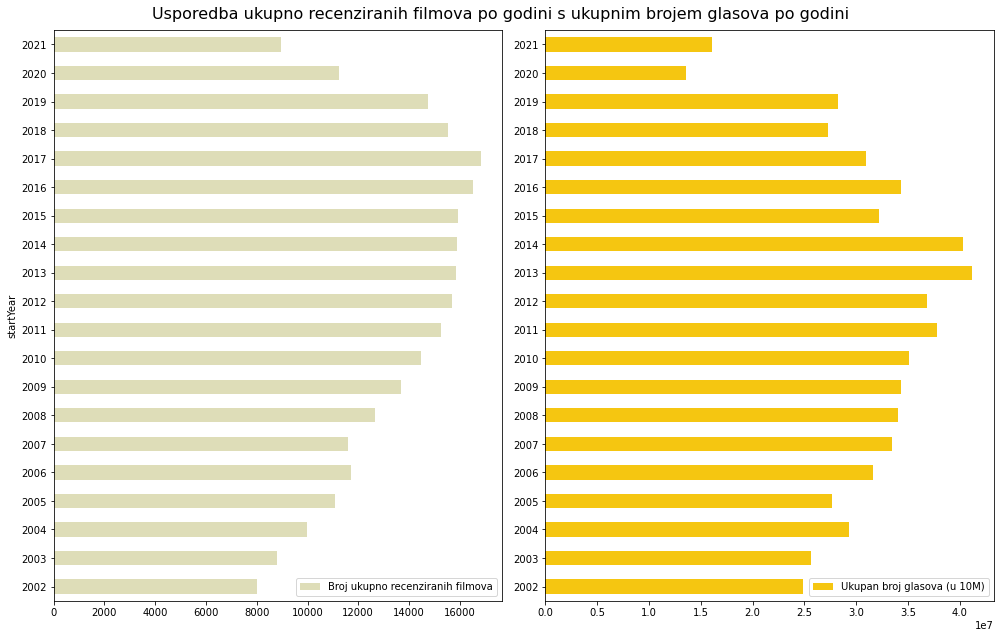

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 9))

titles_df.groupby('startYear').size() \
    .sort_index(ascending=False).head(20)[::-1] \
    .plot.barh(ax=ax[0], color=theme['secondary'])
ax[0].legend(['Broj ukupno recenziranih filmova'], loc='lower right')

titles_df[['startYear', 'numVotes']].groupby('startYear').sum('numVotes') \
    .sort_index(ascending=False).head(20)[::-1] \
    .plot.barh(ax=ax[1], color=theme['primary'])
ax[1].legend(['Ukupan broj glasova (u 10M)'], loc='lower right')
ax[1].set_ylabel(None)

fig.suptitle('Usporedba ukupno recenziranih filmova po godini s ukupnim brojem glasova po godini', fontsize=16)
fig.tight_layout()
plt.show()

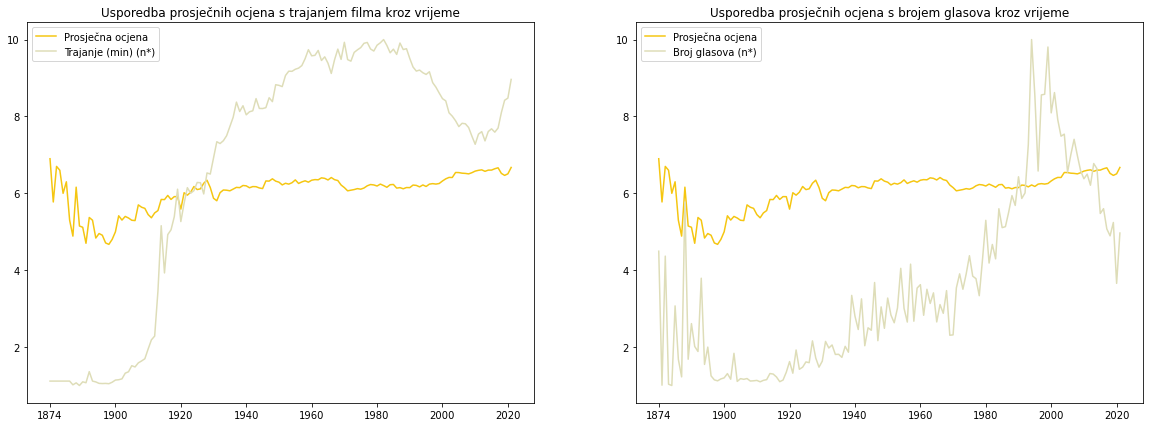

In [6]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler((1, 10))

fig, ax = plt.subplots(ncols=2, figsize=(20, 7))

yearly_ratings_df = titles_df.rename(columns=dict(startYear='Godina')).groupby('Godina').mean()
yearly_ratings_df['numVotes_n'] = normalizer.fit_transform(yearly_ratings_df[['numVotes']])
yearly_ratings_df['runtimeMinutes_n'] = normalizer.fit_transform(yearly_ratings_df[['runtimeMinutes']])


yearly_ratings_df[['averageRating', 'runtimeMinutes_n']] \
    .rename(columns=rename_map).plot(ax=ax[0], color=theme.values())
ax[0].set_title('Usporedba prosječnih ocjena s trajanjem filma kroz vrijeme')
ax[0].set_xlabel(None)

yearly_ratings_df[['averageRating', 'numVotes_n']] \
    .rename(columns=rename_map).plot(ax=ax[1], color=theme.values())
ax[1].set_title('Usporedba prosječnih ocjena s brojem glasova kroz vrijeme')
ax[1].set_xlabel(None)


plt.show()

In [7]:
movie_titles_df = titles_df.loc[(titles_df['titleType'] == 'movie') & (titles_df['startYear'] >= '1970')]
movie_titles_df.sort_values(['numVotes', 'averageRating'], ascending=False).head(20).reset_index(drop=True)

,startYear,titleType,primaryTitle,directorName,genres,averageRating,numVotes,runtimeMinutes
0,1994,movie,The Shawshank Redemption,Frank Darabont,[Drama],9.3,2547412,142
1,2008,movie,The Dark Knight,Christopher Nolan,"[Action, Crime, Drama]",9.0,2497809,152
2,2010,movie,Inception,Christopher Nolan,"[Action, Adventure, Sci-Fi]",8.8,2237262,148
3,1999,movie,Fight Club,David Fincher,[Drama],8.8,2005358,139
4,1994,movie,Forrest Gump,Robert Zemeckis,"[Drama, Romance]",8.8,1965749,142
5,1994,movie,Pulp Fiction,Quentin Tarantino,"[Crime, Drama]",8.9,1959207,154
6,1999,movie,The Matrix,Lana Wachowski,"[Action, Sci-Fi]",8.7,1837591,136
7,2001,movie,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,"[Action, Adventure, Drama]",8.8,1777729,178
8,2003,movie,The Lord of the Rings: The Return of the King,Peter Jackson,"[Action, Adventure, Drama]",8.9,1755900,201
9,1972,movie,The Godfather,Francis Ford Coppola,"[Crime, Drama]",9.2,1752303,175


In [8]:
genres_df = movie_titles_df[['directorName', 'genres', 'averageRating']] \
    .explode('genres').reset_index(drop=True)
genres_df.sample(10)

,directorName,genres,averageRating
121857,Erik Van Looy,Drama,7.3
22631,Maria Lease,Drama,7.0
163055,Philippe Garrel,Drama,6.5
322624,P.J. Bollinger,Crime,6.3
287224,Karina Garcia Casanova,Drama,7.2
306359,Hasan Ramzi,Drama,4.6
107180,Juan N. López Reyes,Crime,4.7
36904,Francis Ford Coppola,Crime,7.6
64235,Mariano Andrade,Crime,3.9
315210,Melly Still,Drama,7.6


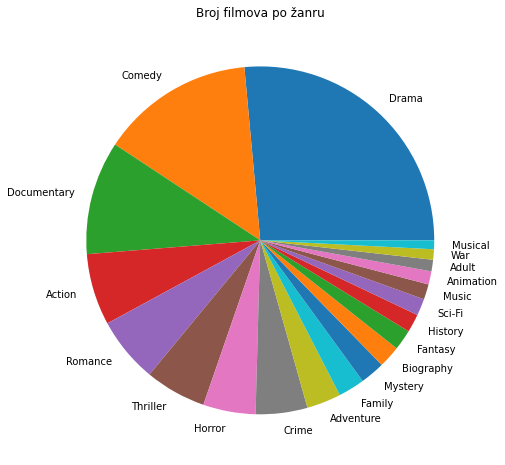

In [9]:
fig, ax = plt.subplots(1, figsize=(8, 8))
fig.set_facecolor('white')

genres_df.genres.value_counts().head(20).plot.pie(ax=ax)
ax.set_title('Broj filmova po žanru')
ax.set_ylabel(None)

plt.show()

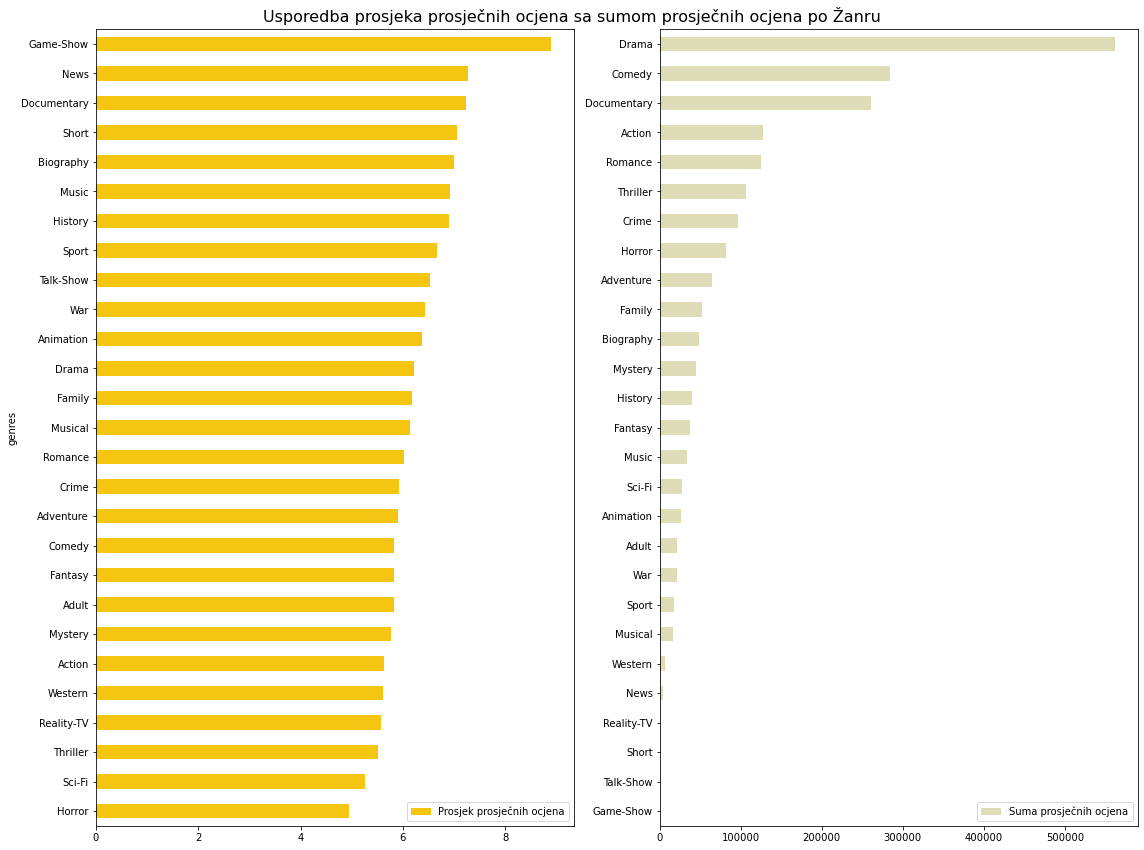

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 12))

genres_df.groupby('genres').mean('averageRating') \
    .sort_values('averageRating').rename(columns=rename_map) \
    .plot.barh(ax=ax[0], color=theme['primary'])
ax[0].legend(['Prosjek prosječnih ocjena'], loc='lower right')

genres_df.groupby('genres').sum('averageRating') \
    .sort_values('averageRating').rename(columns=rename_map) \
    .plot.barh(ax=ax[1], color=theme['secondary'])
ax[1].legend(['Suma prosječnih ocjena'], loc='lower right')
ax[1].set_ylabel(None)

fig.suptitle('Usporedba prosjeka prosječnih ocjena sa sumom prosječnih ocjena po Žanru', fontsize=16)
fig.tight_layout()
plt.show()

In [25]:
genres_df.groupby('directorName').agg(ratings=('averageRating', 'mean')) \
    .sort_values('ratings', ascending=False).rename(columns=dict(ratings='Prosjek prosječnih ocjena')).head(20)[::-1] \
    .sample(1000).plot.barh(figsize=(10, 7), title='Redatelji s najboljim ocjenama', color=theme['primary'])
plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [12]:
X_name = ['directorName', 'genres']
y_name = ['averageRating']

movie_titles_df = titles_df.loc[:, X_name + y_name]
directors_idx = {director_name: director_id+1 for director_id, director_name in enumerate(movie_titles_df.directorName.unique())}
movie_titles_df['directorID'] = movie_titles_df['directorName'].transform(lambda x: directors_idx[x])
# movie_titles_df.groupby(['directorName', 'numVotes']).mean('averageRating').sort_index(level='numVotes', ascending=False)
movie_titles_df

,directorName,genres,averageRating,directorID
0,William K.L. Dickson,"[Documentary, Short]",5.7,1
1,Émile Reynaud,"[Animation, Short]",6.0,2
2,Émile Reynaud,"[Animation, Comedy, Romance]",6.5,2
3,Émile Reynaud,"[Animation, Short]",6.0,2
4,William K.L. Dickson,"[Comedy, Short]",6.2,1
...,...,...,...,...
457434,Gabriel Athanasiou,[Comedy],9.3,134490
457435,Azhar Kinoi Lubis,[Drama],8.3,67212
457436,Jason Bradbury,"[Drama, Short]",7.0,65391
457437,Niclas Schmidt,"[Comedy, Horror, Mystery]",5.5,67567


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

dataset = movie_titles_df.dropna().reset_index(drop=True)

mlb = MultiLabelBinarizer()
mlb_df = pd.DataFrame(mlb.fit_transform(dataset.pop('genres')),
    columns=mlb.classes_,
    index=dataset.index
)
mlb_df

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456606,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
456607,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
456608,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
456609,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dataset.join(mlb_df)

,directorName,averageRating,directorID,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,William K.L. Dickson,5.7,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Émile Reynaud,6.0,2,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Émile Reynaud,6.5,2,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,Émile Reynaud,6.0,2,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,William K.L. Dickson,6.2,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456606,Gabriel Athanasiou,9.3,134490,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
456607,Azhar Kinoi Lubis,8.3,67212,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
456608,Jason Bradbury,7.0,65391,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
456609,Niclas Schmidt,5.5,67567,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
dataset_model = dataset.join(mlb_df)
dataset_model['rating'] = dataset_model.averageRating.transform(lambda x:
    5 if x >= 8.5 else
    4 if x < 8.5 and x >= 7.5 else
    3 if x < 7.5 and x >= 6 else
    2 if x < 6 and x >= 4.5 else
    1
)
dataset_model = dataset_model.drop(['directorName', 'averageRating'], axis=1)

y_name = ['rating']

X = dataset_model.drop(y_name, axis=1)
y = dataset_model[y_name]

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456611 entries, 0 to 456610
Data columns (total 29 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   directorID   456611 non-null  int64
 1   Action       456611 non-null  int32
 2   Adult        456611 non-null  int32
 3   Adventure    456611 non-null  int32
 4   Animation    456611 non-null  int32
 5   Biography    456611 non-null  int32
 6   Comedy       456611 non-null  int32
 7   Crime        456611 non-null  int32
 8   Documentary  456611 non-null  int32
 9   Drama        456611 non-null  int32
 10  Family       456611 non-null  int32
 11  Fantasy      456611 non-null  int32
 12  Film-Noir    456611 non-null  int32
 13  Game-Show    456611 non-null  int32
 14  History      456611 non-null  int32
 15  Horror       456611 non-null  int32
 16  Music        456611 non-null  int32
 17  Musical      456611 non-null  int32
 18  Mystery      456611 non-null  int32
 19  News         456611 non

In [17]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456611 entries, 0 to 456610
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   rating  456611 non-null  int64
dtypes: int64(1)
memory usage: 3.5 MB


<AxesSubplot:xlabel='rating'>

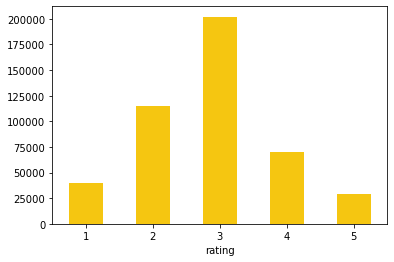

In [18]:
y.groupby('rating')['rating'].size().plot.bar(color=theme['primary'], rot=0)

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

over_sampler = RandomOverSampler(sampling_strategy={1: 90000, 4: 90000, 5: 90000})
under_sampler = RandomUnderSampler(sampling_strategy={2: 90000, 3: 90000})

over_sampled_X, over_sampled_y = over_sampler.fit_resample(X, y)
balanced_X, balanced_y = under_sampler.fit_resample(over_sampled_X, over_sampled_y)

<AxesSubplot:xlabel='rating'>

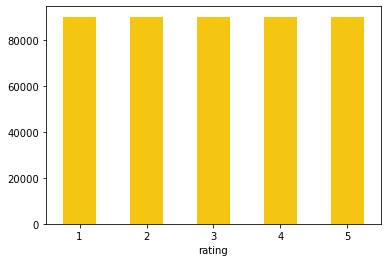

In [20]:
balanced_y.groupby('rating')['rating'].size().plot.bar(color=theme['primary'], rot=0)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

config = [
    {
        'name': 'Decision Tree Classifier',
        'Classifier': DecisionTreeClassifier,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': None,
            'max_depth': None,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Decision Tree Classifier',
        'Classifier': DecisionTreeClassifier,
        'X': X,
        'y': y,
        'params': {
            'random_state': 420,
            'max_depth': 10,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Decision Tree Classifier',
        'Classifier': DecisionTreeClassifier,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': 42,
            'max_depth': 20,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Decision Tree Classifier',
        'Classifier': DecisionTreeClassifier,
        'X': X,
        'y': y,
        'params': {
            'random_state': 42,
            'max_depth': 30,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Random Forest Classifier',
        'Classifier': RandomForestClassifier,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': 42,
            'max_depth': None,
            'n_jobs': -1
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Random Forest Classifier',
        'Classifier': RandomForestClassifier,
        'X': X,
        'y': y,
        'params': {
            'random_state': 420,
            'max_depth': 10,
            'n_jobs': -1
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Random Forest Classifier',
        'Classifier': RandomForestClassifier,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': 42,
            'max_depth': 20,
            'n_jobs': -1
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Random Forest Classifier',
        'Classifier': RandomForestClassifier,
        'X': X,
        'y': y,
        'params': {
            'random_state': 42,
            'max_depth': 30,
            'n_jobs': -1
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'MLP Classifier',
        'Classifier': MLPClassifier,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': 420,
            'hidden_layer_sizes': (3, 1),
            'solver': 'lbfgs',
            'alpha': 0.0001,
            'max_iter': 100,
            'early_stopping': True,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'MLP Classifier',
        'Classifier': MLPClassifier,
        'X': X,
        'y': y,
        'params': {
            'random_state': 420,
            'hidden_layer_sizes': (3, 2),
            'solver': 'adam',
            'alpha': 0.00001,
            'max_iter': 100,
            'early_stopping': True,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'MLP Classifier',
        'Classifier': MLPClassifier,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': 420,
            'hidden_layer_sizes': (5, 2),
            'solver': 'sgd',
            'alpha': 0.0001,
            'learning_rate': 'adaptive',
            'max_iter': 200,
            'early_stopping': True,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'MLP Classifier',
        'Classifier': MLPClassifier,
        'X': X,
        'y': y,
        'params': {
            'random_state': 42,
            'hidden_layer_sizes': (5, 3),
            'solver': 'lbfgs',
            'alpha': 0.0001,
            'max_iter': 500,
            'early_stopping': True,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Multinomial Logistic Regression',
        'Classifier': LogisticRegression,
        'X': X,
        'y': y,
        'params': {
            'random_state': 420,
            'penalty': 'none',
            'solver': 'lbfgs',
            'multi_class': 'multinomial',
            'max_iter': 500,
        },
        'train_score': 0,
        'test_score': 0,
    },
    {
        'name': 'Multinomial Logistic Regression',
        'Classifier': LogisticRegression,
        'X': balanced_X,
        'y': balanced_y,
        'params': {
            'random_state': 42,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'multi_class': 'multinomial',
            'max_iter': 500,
        },
        'train_score': 0,
        'test_score': 0,
    },
]


for i, item in enumerate(config):
    print("RUN#{} `{}`".format(i+1, item['name']))
    if item['X'] is balanced_X:
        print("using balanced dataset")
    else:
        print("using original dataset")
    print("params: {}".format(json.dumps(item['params']), indent=2))
    
    X_train, X_test, y_train, y_test = train_test_split(
        item['X'], item['y'], 
        test_size=0.3,
        random_state=42
    )
    
    Classifier = item['Classifier']
    clf = Classifier(**item['params'])
    
    if Classifier is MLPClassifier:
        X_train = X_train.values
        X_test = X_test.values
    
    clf.fit(X_train, y_train.values.reshape(1, -1)[0])
    
    item['Classifier'] = clf
    item['train_score'] = round(clf.score(X_train, y_train.values), 2)
    item['test_score'] = round(clf.score(X_test, y_test.values), 2)

    print("- train_score:       {:.2f}".format(item['train_score']))
    print("- test_score:        {:.2f}".format(item['test_score']))
    print("\n")

with open(os.path.join(settings.DATASET_DIR, 'scores.json'), 'w') as f:
    json.dump(config, f, indent=4, default=str)

RUN#1 `Decision Tree Classifier`
using balanced dataset
params: {"random_state": null, "max_depth": null}
- train_score:       0.92
- test_score:        0.57


RUN#2 `Decision Tree Classifier`
using original dataset
params: {"random_state": 420, "max_depth": 10}
- train_score:       0.47
- test_score:        0.46


RUN#3 `Decision Tree Classifier`
using balanced dataset
params: {"random_state": 42, "max_depth": 20}
- train_score:       0.50
- test_score:        0.42


RUN#4 `Decision Tree Classifier`
using original dataset
params: {"random_state": 42, "max_depth": 30}
- train_score:       0.66
- test_score:        0.44


RUN#5 `Random Forest Classifier`
using balanced dataset
params: {"random_state": 42, "max_depth": null, "n_jobs": -1}
- train_score:       0.92
- test_score:        0.57


RUN#6 `Random Forest Classifier`
using original dataset
params: {"random_state": 420, "max_depth": 10, "n_jobs": -1}
- train_score:       0.46
- test_score:        0.46


RUN#7 `Random Forest Classif

C:\Users\AndreaHrelja\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


- train_score:       0.25
- test_score:        0.25


RUN#13 `Multinomial Logistic Regression`
using original dataset
params: {"random_state": 420, "penalty": "none", "solver": "lbfgs", "multi_class": "multinomial", "max_iter": 500}
- train_score:       0.44
- test_score:        0.44


RUN#14 `Multinomial Logistic Regression`
using balanced dataset
params: {"random_state": 42, "penalty": "l2", "solver": "lbfgs", "multi_class": "multinomial", "max_iter": 500}
- train_score:       0.20
- test_score:        0.20




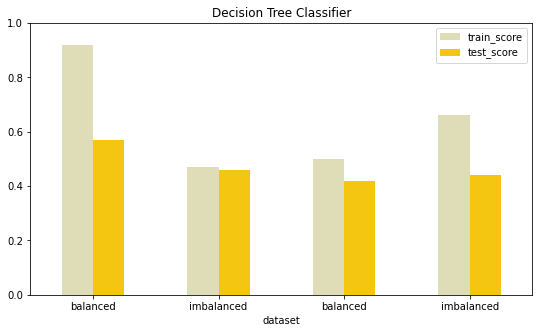

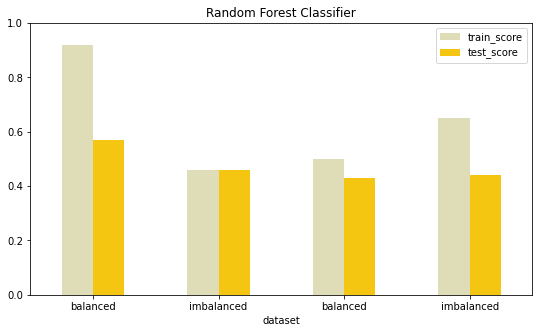

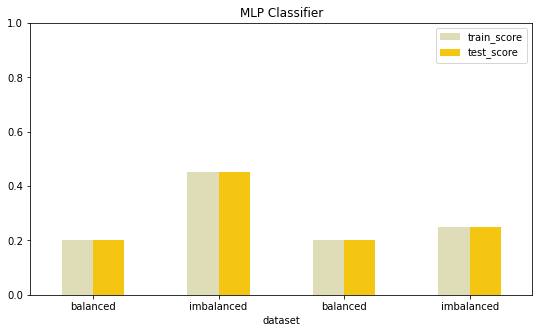

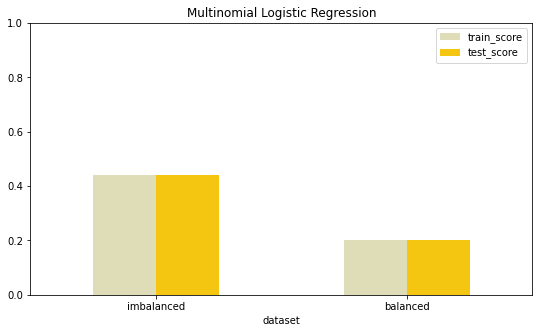

In [28]:
data = [
    {
        'name': item['name'],
        'train_score': item['train_score'],
        'test_score': item['test_score'],
        'dataset': 'balanced' if item['X'] is balanced_X else 'imbalanced'
    } for item in config
]

scores_df = pd.DataFrame(data)
for name in scores_df.name.unique():
    scores_df[scores_df['name'] == name] \
        .set_index('dataset').plot.bar(
            title="{}".format(name), rot=0,
            figsize=(9, 5), ylim=(0, 1), color=[
                theme['secondary'],
                theme['primary']
            ]
        )


In [23]:
index = [
    'Christopher Nolan', 
    'Lamberto Sanfelice'
]

X_to_predict = pd.DataFrame([
    {
        'directorID': directors_idx['Christopher Nolan'],
        'Action':           0,
        'Adult':            0,
        'Adventure':        0,
        'Animation':        0,
        'Biography':        0,
        'Comedy':           0,
        'Crime':            0,
        'Documentary':      0,
        'Drama':            1,
        'Family':           0,
        'Fantasy':          1,
        'Film-Noir':        0,
        'Game-Show':        0,
        'History':          0,
        'Horror':           0,
        'Music':            0,
        'Musical':          0,
        'Mystery':          0,
        'News':             0,
        'Reality-TV':       0,
        'Romance':          0,
        'Sci-Fi':           1,
        'Short':            0,
        'Sport':            0,
        'Talk-Show':        0,
        'Thriller':         0,
        'War':              0,
        'Western':          0,
    },
    {
        'directorID': directors_idx['Lamberto Sanfelice'],
        'Action':           0,
        'Adult':            0,
        'Adventure':        0,
        'Animation':        0,
        'Biography':        0,
        'Comedy':           0,
        'Crime':            0,
        'Documentary':      0,
        'Drama':            1,
        'Family':           0,
        'Fantasy':          0,
        'Film-Noir':        0,
        'Game-Show':        0,
        'History':          0,
        'Horror':           0,
        'Music':            0,
        'Musical':          0,
        'Mystery':          0,
        'News':             0,
        'Reality-TV':       0,
        'Romance':          0,
        'Sci-Fi':           0,
        'Short':            0,
        'Sport':            0,
        'Talk-Show':        0,
        'Thriller':         0,
        'War':              0,
        'Western':          0,
    }
], index=index)

for item in config:
    clf = item['Classifier']
    if isinstance(clf, MLPClassifier):
        predictions = clf.predict(X_to_predict.values)
    else:
        predictions = clf.predict(X_to_predict)
    
    print(item['name'])
    if item['X'] is balanced_X:
        print("using balanced dataset")
    else:
        print("using original dataset")
    print(item['params'])
    print("- Christopher Nolan (Drama, Action, Crime): ", predictions[0])
    print("- Lamberto Sanfelice (Drama): ", predictions[1])
    print("\n")

Decision Tree Classifier
using balanced dataset
{'random_state': None, 'max_depth': None}
- Christopher Nolan (Drama, Action, Crime):  2
- Lamberto Sanfelice (Drama):  2


Decision Tree Classifier
using original dataset
{'random_state': 420, 'max_depth': 10}
- Christopher Nolan (Drama, Action, Crime):  3
- Lamberto Sanfelice (Drama):  3


Decision Tree Classifier
using balanced dataset
{'random_state': 42, 'max_depth': 20}
- Christopher Nolan (Drama, Action, Crime):  3
- Lamberto Sanfelice (Drama):  1


Decision Tree Classifier
using original dataset
{'random_state': 42, 'max_depth': 30}
- Christopher Nolan (Drama, Action, Crime):  4
- Lamberto Sanfelice (Drama):  3


Random Forest Classifier
using balanced dataset
{'random_state': 42, 'max_depth': None, 'n_jobs': -1}
- Christopher Nolan (Drama, Action, Crime):  4
- Lamberto Sanfelice (Drama):  2


Random Forest Classifier
using original dataset
{'random_state': 420, 'max_depth': 10, 'n_jobs': -1}
- Christopher Nolan (Drama, Action, Cr